# Importing Libraries

In [1]:
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import os
import torch
from torchvision.io import read_image
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm

 Defining batch size

In [56]:
batch_size = 32

# Loading The Data Set

In [53]:


class LandscapeDataset(Dataset):
    def __init__(self, transform=None):
        #Loading the dataset
        self.dataroot = './landscapeImages'
        self.images = os.listdir(f'{self.dataroot}/gray/gray')
        self.transform = transform

    def __len__(self):
        #Returns number of samples in dataset
        return len(self.images)

    def __getitem__(self, idx):
        #Function loads and returns a sample from the dataset at the given index 
        img_path = self.images[idx]

        color_img = read_image(f'{self.dataroot}/color/color/{img_path}') / 255
        gray_img = read_image(f'{self.dataroot}/gray/gray/{img_path}') / 255

        if self.transform:
            color_img = self.transform(color_img)
            gray_img = self.transform(gray_img)

        return color_img, gray_img

# Use torchvision.transforms.functional.resize for tensor resizing
transform = transforms.Compose([transforms.Resize((150, 150))])

dataset = LandscapeDataset(transform=transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_set, test_set = random_split(dataset, [train_size, test_size], generator=torch.Generator())

train_loader = DataLoader(train_set, batch_size=batch_size)
test_loader = DataLoader(test_set, batch_size=batch_size)


Printing the Image Shapes

In [57]:
print(color_img[0].shape)
print(gray_img[0].shape)

torch.Size([3, 150, 150])
torch.Size([1, 150, 150])


# Plotting the images

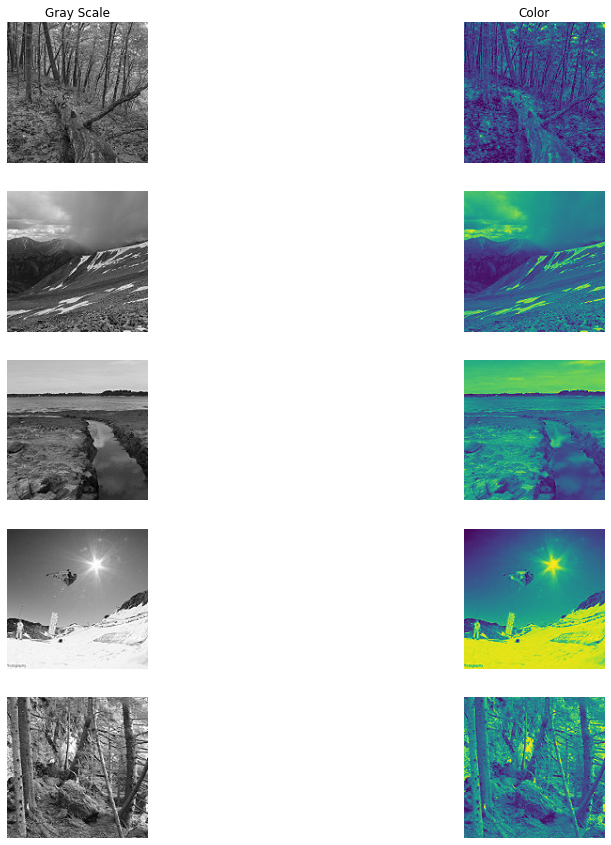

In [55]:
def show_images(color, gray):
    fig, axs = plt.subplots(5, 2, figsize=(15, 15))
    axs[0, 0].set_title('Gray Scale')
    axs[0, 1].set_title('Color')

    for i in range(5):
        # For grayscale images
        axs[i, 0].imshow(gray[i][0], cmap='gray')
        axs[i, 0].axis('off')

        # For color images
        axs[i, 1].imshow(color[i][0])
        axs[i, 1].axis('off')

    plt.show()

color, gray = next(iter(train_loader))
show_images(color, gray)


# Defining the Neural Network Architecture

In [58]:
class Color_auto_encoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.down1=nn.Conv2d(1,64,3,stride=2)
        self.down2=nn.Conv2d(64,128,3,stride=2,padding=1)
        self.down3=nn.Conv2d(128,256,3,stride=2,padding=1)
        self.down4=nn.Conv2d(256,512,3,stride=2,padding=1)
        
        self.up1=nn.ConvTranspose2d(512,256,3,stride=2,padding=1)
        self.up2=nn.ConvTranspose2d(512,128,3,stride=2,padding=1)
        self.up3=nn.ConvTranspose2d(256,64,3,stride=2,padding=1,output_padding=1)
        self.up4=nn.ConvTranspose2d(128,3,3,stride=2,output_padding=1)
        
        self.relu=nn.ReLU()
        self.sigmoid=nn.Sigmoid()
        
    def forward(self,x):
        d1=self.relu(self.down1(x))
        d2=self.relu(self.down2(d1))
        d3=self.relu(self.down3(d2))
        d4=self.relu(self.down4(d3))
        
        u1=self.relu(self.up1(d4))
        u2=self.relu(self.up2(torch.cat((u1,d3),dim=1)))
        u3=self.relu(self.up3(torch.cat((u2,d2),dim=1)))
        u4=self.relu(self.up4(torch.cat((u3,d1),dim=1)))
        
        return u4

Assigning to device

In [52]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Initialize the model, loss function, and optimizer

In [19]:
# Initialize the model, loss function, and optimizer
model = Color_auto_encoder().to(device)
criterion = nn.MSELoss()  # You can choose a different loss function if desired
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs=10

# Training the Neural Network

In [38]:
train_loss=0
for epoch in range(num_epochs):
    for idx,(color_img,gray_img) in tqdm(enumerate(train_loader),total=len(train_loader)):
        color_img=color_img.to(device)
        gray_img=gray_img.to(device)
        
        predictions=model(gray_img)
        optimizer.zero_grad()
        
        loss=criterion(color_img,predictions)
        
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()
    avg_train_loss = train_loss / len(train_loader)
    print(f'Training Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_train_loss:.4f}')    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Training Epoch [1/10], Loss: 0.0062
Epoch [1/10], Loss: 0.0051



Training Epoch [2/10], Loss: 0.0123
Epoch [2/10], Loss: 0.0047



Training Epoch [3/10], Loss: 0.0183
Epoch [3/10], Loss: 0.0049



Training Epoch [4/10], Loss: 0.0242
Epoch [4/10], Loss: 0.0049



Training Epoch [5/10], Loss: 0.0301
Epoch [5/10], Loss: 0.0050



Training Epoch [6/10], Loss: 0.0358
Epoch [6/10], Loss: 0.0049



Training Epoch [7/10], Loss: 0.0414
Epoch [7/10], Loss: 0.0044



Training Epoch [8/10], Loss: 0.0470
Epoch [8/10], Loss: 0.0041



Training Epoch [9/10], Loss: 0.0525
Epoch [9/10], Loss: 0.0040



Training Epoch [10/10], Loss: 0.0579
Epoch [10/10], Loss: 0.0040


# Saving the model

In [59]:
# Save the trained model
save_path = 'model_colorize_auto_encoder.pth'
torch.save(model.state_dict(), save_path)

Validation Epoch [10/10], Loss: 0.0073


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


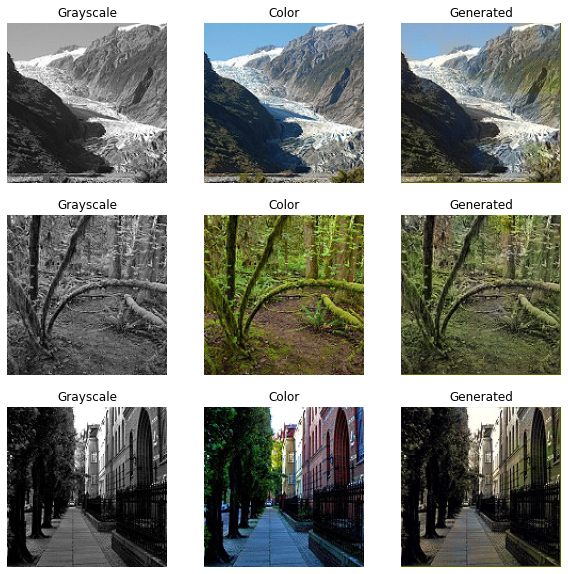

In [60]:
# Set the model to evaluation mode
model.eval()
val_loss = 0.0
# Initialize lists to store results
all_test_color = []
all_test_gray = []
all_test_generated = []

# Iterate over the test dataset
with torch.no_grad():
    for test_color, test_gray in test_loader:
        test_color = test_color.to(device)
        test_gray = test_gray.to(device)

        # Forward pass
        test_generated = model(test_gray)
        val_loss += criterion(test_generated, test_color).item()
        # Append results to lists
        all_test_color.append(test_color.cpu())
        all_test_gray.append(test_gray.cpu())
        all_test_generated.append(test_generated.cpu())

avg_val_loss = val_loss / len(test_loader)
print(f'Validation Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_val_loss:.4f}')

# Concatenate results from all batches
all_test_color = torch.cat(all_test_color, dim=0)
all_test_gray = torch.cat(all_test_gray, dim=0)
all_test_generated = torch.cat(all_test_generated, dim=0)

# Define the modified show_images function
def show_images(color, gray, generated):
    fig, axs = plt.subplots(3, 3, figsize=(10, 10))


    for i in range(3):  # Change this line to range(5)
        axs[i, 0].set_title('Grayscale')
        axs[i, 1].set_title('Color')
        axs[i, 2].set_title('Generated')

        axs[i, 0].imshow(gray[i].squeeze().cpu(), cmap='gray')  # Squeeze to remove the channel dimension
        axs[i, 0].axis('off')
        axs[i, 1].imshow(color[i].permute(1, 2, 0).cpu())
        axs[i, 1].axis('off')
        axs[i, 2].imshow(generated[i].permute(1, 2, 0).cpu())
        axs[i, 2].axis('off')

    plt.show()


# Display images
show_images(all_test_color, all_test_gray, all_test_generated)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


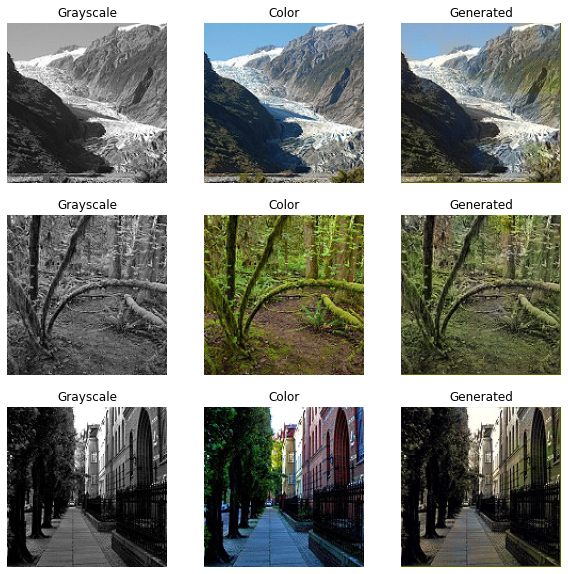

In [61]:
# Set the model to evaluation mode
model.eval()

# Initialize lists to store results
all_test_color = []
all_test_gray = []
all_test_generated = []

# Iterate over the test dataset
with torch.no_grad():
    for test_color, test_gray in test_loader:
        test_color = test_color.to(device)
        test_gray = test_gray.to(device)

        # Forward pass
        test_generated = model(test_gray)

        # Append results to lists
        all_test_color.append(test_color.cpu())
        all_test_gray.append(test_gray.cpu())
        all_test_generated.append(test_generated.cpu())

# Concatenate results from all batches
all_test_color = torch.cat(all_test_color, dim=0)
all_test_gray = torch.cat(all_test_gray, dim=0)
all_test_generated = torch.cat(all_test_generated, dim=0)

# Display images
show_images(all_test_color, all_test_gray, all_test_generated)


# Testing for new data

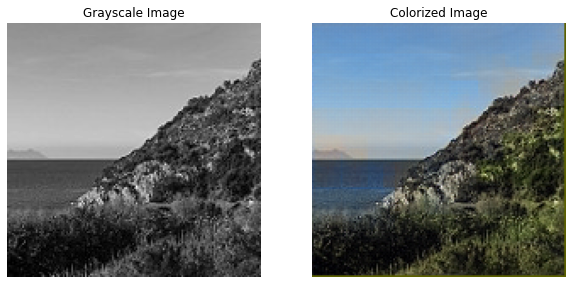

In [78]:
# Load the trained model
model_path = 'model_colorize_auto_encoder.pth'
model = Color_auto_encoder()  # Replace with your actual model class
model.load_state_dict(torch.load(model_path))
model.eval()

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
])

# Load and transform a grayscale image
grayscale_image_path = 'test/17.jpg'
grayscale_image = Image.open(grayscale_image_path).convert('L')  # Convert to grayscale
input_image = transform(grayscale_image).unsqueeze(0)  # Add batch dimension

# Colorize the image using the trained model
with torch.no_grad():
    colorized_image = model(input_image)

# Visualize the images
fig, axs = plt.subplots(1, 2, figsize=(10, 200))

axs[0].imshow(grayscale_image, cmap='gray')
axs[0].axis('off')
axs[0].set_title('Grayscale Image')

axs[1].imshow(colorized_image.squeeze().permute(1, 2, 0))
axs[1].axis('off')
axs[1].set_title('Colorized Image')

plt.show()
